In [1]:
# Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns

### Task 1
1. Load the two datasets.
2. Select a classifier, train a model on dataset A. 
3. Evaluate the generalization error.

In [2]:
# Task 1.1

# Loading the datasets
X_data_A = pd.read_csv(r"features_dataset_A.csv", header=None, delimiter=';').to_numpy()
y_data_A = pd.read_csv(r"targets_dataset_A.csv", header=None).to_numpy().ravel()

X_data_B = pd.read_csv(r"features_dataset_B.csv", header=None, delimiter=';').to_numpy()
y_data_B = pd.read_csv(r"targets_dataset_B.csv", header=None).to_numpy().ravel()

# 80/20 train test split
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_data_A, y_data_A, test_size=0.2, random_state=42)

In [3]:
# Task 1.2 + 1.3

# Training a standard random forest classsifier
rand_forest_model = RandomForestClassifier(random_state=42)

# K fold cross validation with
k=100
rand_forest_mean_cross_val_A = np.mean(cross_val_score(rand_forest_model, X_train_A, y_train_A, cv=k, scoring='roc_auc'))

# Fitting the model and making predictions
rand_forest_model_A = rand_forest_model.fit(X_train_A, y_train_A)
predictions_A = rand_forest_model_A.predict(X_test_A)

# Getting the R2 score on the predictions
rand_forest_rocauc_A = roc_auc_score(y_true=y_test_A, y_score=predictions_A)

# Printing the values
print(f"\n*** Evaluation metrics for Random forest classifier on dataset A ***\n")
print(f"    ROC/AUC = {rand_forest_rocauc_A:.4f}")
print(f"    Mean cross validation with ROC/AUC scores and k={k} folds = {rand_forest_mean_cross_val_A:.4f}\n")
print(f"Based on this very basic evaluation, we can see that the model has a good fit since the ROC/AUC scoreas are close to 1 and do not differ much.")


*** Evaluation metrics for Random forest classifier on dataset A ***

    ROC/AUC = 0.9170
    Mean cross validation with ROC/AUC scores and k=100 folds = 0.9314

Based on this very basic evaluation, we can see that the model has a good fit since the ROC/AUC scoreas are close to 1 and do not differ much.


### Task 2
1. Test the model on the dataset B (production dataset).
2. How well is the trained classifier performing on the production dataset? Is it better or worse than on the generalization error 
of dataset A?

In [4]:
#Task 2.1 + 2.2

# using the random forsest model that we trained on dataset A to predict the datapoints in dataset B
predictions_B = rand_forest_model_A.predict(X_data_B)

rand_forest_rocauc_B = roc_auc_score(y_true=y_data_B, y_score=predictions_B)
percentage_diff = (1 - (rand_forest_rocauc_B / rand_forest_rocauc_A))*100

# Printing the values
print(f"\n*** Evaluation metrics for Random forest classifier on dataset B ***\n")
print(f"    ROC/AUC = {rand_forest_rocauc_B:.4f}\n")
print(f"Based on this very basic evaluation, we can see that the model we trained on dataset A is {percentage_diff:.2f}% less accurate when predicting the data in dataset B.")


*** Evaluation metrics for Random forest classifier on dataset B ***

    ROC/AUC = 0.8881

Based on this very basic evaluation, we can see that the model we trained on dataset A is 3.16% less accurate when predicting the data in dataset B.


### Task 3
1. Measure how the features are changing over time (concept drift) with the Kolmogorov-Smirnov Test to see if the distribution of the features remains constant or if they are changing over time. 
    - Your reference distribution can be the 250 first values of dataset A, called FEATURE_SAMPLES_DS_A. 
    - First try to do a K-S Test between FEATURE_SAMPLES_DS_A and for indeces 0 to 250 of the production dataset B. 
    - Do they having the same distribution? Can we reject the null hypothesis?
2. Do a K-S Test between FEATURE_SAMPLES_DS_A and for indeces 250 to 500 of the production dataset B. 
    - Are they having the same distribution? 
    - Can we reject the null hypothesis?
3. Try other windows in the production dataset B. 
    - Estimate where the concept drift starts (at which index in dataset B)? 
    - Which type of concept shift occurs: abrupt gradual or incremental?

*** Notes to self ***
- Our null hypothesis is that the samples are drawn from the same distributions, and we select a 95% confidence interval for a two sided test by setting alpha to 0.025. 
- If the p-value we calculate from the D statistic is smaller than 0.025 or greater than 0.975, we reject the null hypothesis.
- Rejecting the null hypothesis means that the two samples likely come from different distributions.
- Failing to reject means that the two samples likely come from the same distribution. 

In [5]:
# task 3.1

# Implementing a function that returns True if we can reject the null hypothesis given a confidence interval, else False.
def KS_test_hypothesis_evaluation(reference_distribution_samples, comparisson_samples, alpha, print_res=False):

    d_statistic, pval = ks_2samp(reference_distribution_samples.ravel(), comparisson_samples.ravel())

    if pval < alpha or pval > 1-alpha:
        reject_hypothesis = True
    else:
        reject_hypothesis = False

    if print_res and reject_hypothesis==True:
        print(f"We reject the null hypothesis, the samples come from different distributions.\n")
    
    elif print_res and reject_hypothesis==False:
        print(f"We fail to reject the null hypothesis, the samples come from the same distribution.\n")

    return reject_hypothesis, d_statistic, pval

# Setting aside the initial 250 datapoints in dataset A and B to do an initial test
feature_samples_DS_A = X_data_A[:250, :]
feature_samples_DS_B_0_250 = X_data_B[:250, :]

# Setting the value of alpha for the null hypothesis
h0_alpha = 0.025

# Calling the evaluation function
null_hypothesis_rejects = KS_test_hypothesis_evaluation(feature_samples_DS_A, feature_samples_DS_B_0_250, h0_alpha, print_res=True)

We fail to reject the null hypothesis, the samples come from the same distribution.



In [6]:
# Task 3.2

# Selecting a new subset of dataset B
feature_samples_DS_B_250_500 = X_data_B[250:500, :]

# Calling the evaluation function again 
null_hypothesis_rejects = KS_test_hypothesis_evaluation(feature_samples_DS_A, feature_samples_DS_B_250_500, h0_alpha, print_res=True)

We reject the null hypothesis, the samples come from different distributions.



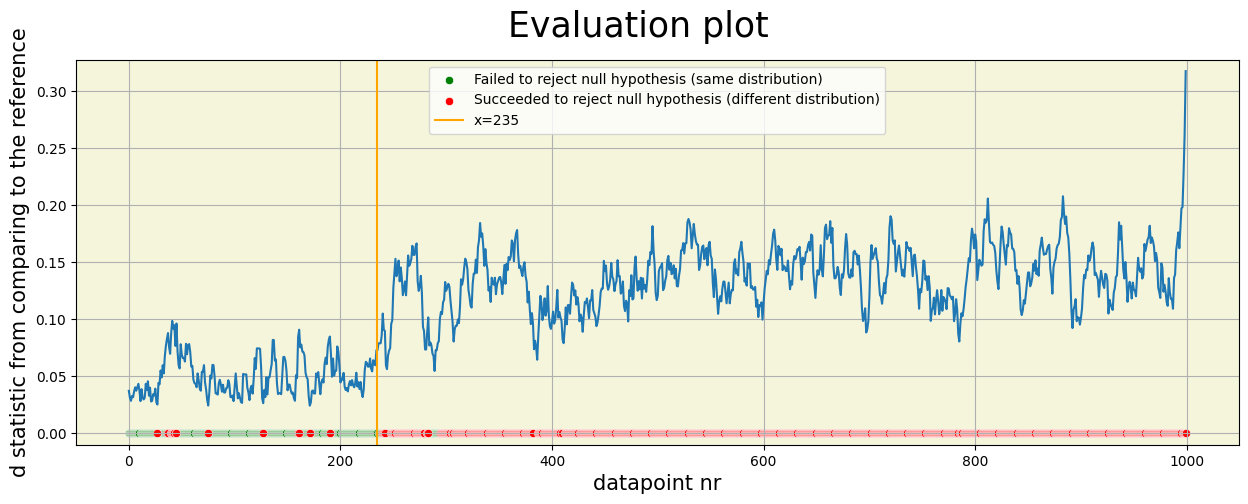

From looking at the rejected null hypothesies, we can see that we have a gradual shift starting from around index 28 and lasting up until an abrupt shift around index 235.
From around index 225 and onwards, we can also observe a sharp and lasting increase in the d-statistic (meaning they are distant to the reference distribution) which further supports this conclusion. 


In [7]:
# Task 3.3

# Iteratively comparing each datapoint in dataset B against the reference window from dataset A, 
d_statistics = []
hypothesis_rejects = []
hypothesis_reject_fails = []

for i in range(X_data_B.shape[0]):
    reject_hypothesis, d_statistic, _ = KS_test_hypothesis_evaluation(feature_samples_DS_A, X_data_B[i:i+10], h0_alpha)
    d_statistics.append(d_statistic)
    if reject_hypothesis:
        hypothesis_rejects.append(1)
        hypothesis_reject_fails.append(0)
    else:
        hypothesis_rejects.append(0)
        hypothesis_reject_fails.append(1)

# plotting the D statistics for each datapoint with 
fig, ax = plt.subplots(1, 1, figsize=(15,5))
fig.suptitle("Evaluation plot", fontsize=25)

sns.lineplot(x=range(len(d_statistics)), y=d_statistics, ax=ax)
sns.scatterplot(x=range(len(hypothesis_rejects)), y=hypothesis_rejects, ax=ax, color='green', label="Failed to reject null hypothesis (same distribution)")
sns.scatterplot(x=range(len(hypothesis_reject_fails)), y=hypothesis_reject_fails, ax=ax, color='red', label="Succeeded to reject null hypothesis (different distribution)")
#ax.axvline(x=28, color='purple', label="x=28")
ax.axvline(x=235, color='orange', label="x=235")

ax.set_ylim(-0.01, d_statistics[-1]+0.01)
ax.grid()
ax.set_xlabel("datapoint nr", fontsize=15)
ax.set_ylabel("d statistic from comparing to the reference", fontsize=15)
ax.set_facecolor('beige')
ax.legend()

plt.show()

print(f"From looking at the rejected null hypothesies, we can see that we have a gradual shift starting from around index 28 and lasting up until an abrupt shift around index 235.")
print(f"From around index 225 and onwards, we can also observe a sharp and lasting increase in the d-statistic (meaning they are distant to the reference distribution) which further supports this conclusion. ")

### Task 4
1. Retrain the model with parts of dataset B occurring after the start of the concept drift (which could be estimated in the third task). 
    - How is the generalization error now? Is it improved?

In [8]:
# Task 4.1

# Selecting a subset of X_data_B based on the previous estimation pf where the concept drift occurs
X_data_B_subset = X_data_B[235:, :]
y_data_B_subset = y_data_B[235:]

# 80/20 train test split
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_data_B_subset, y_data_B_subset, test_size=0.2, random_state=42)

# K fold cross validation with
k=100
rand_forest_mean_cross_val_B = np.mean(cross_val_score(rand_forest_model, X_train_B, y_train_B, cv=k, scoring='roc_auc'))

# Fitting the model and making predictions
rand_forest_model_B = rand_forest_model.fit(X_train_B, y_train_B)
predictions_B = rand_forest_model_A.predict(X_test_B)

# Getting the R2 score on the predictions
rand_forest_rocauc_B = roc_auc_score(y_true=y_test_B, y_score=predictions_B)

# Printing the values
print(f"\n*** Evaluation metrics for Random forest classifier on dataset A ***\n")
print(f"    ROC/AUC = {rand_forest_rocauc_B:.4f}")
print(f"    Mean cross validation with ROC/AUC scores and k={k} folds = {rand_forest_mean_cross_val_B:.4f}\n")
print(f"Here we can see that the model has a good fit since the ROC/AUC scoreas are close to 1 and do not differ much, like when training and evaluating on datasety A in the beginning.")
print(f"Furthermore, we can see that we have managed to gain back the performance that we previously lost due to concept drift.")


*** Evaluation metrics for Random forest classifier on dataset A ***

    ROC/AUC = 0.9182
    Mean cross validation with ROC/AUC scores and k=100 folds = 0.9203

Here we can see that the model has a good fit since the ROC/AUC scoreas are close to 1 and do not differ much, like when training and evaluating on datasety A in the beginning.
Furthermore, we can see that we have managed to gain back the performance that we previously lost due to concept drift.
